In [ ]:
#Always activate the environment before running this notebook!
#cd /Users/glusker/Documents/courses/CAS_ADS/Module6/M6project
#source venv/bin/activate

Imprt libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Data preparation

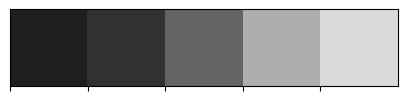

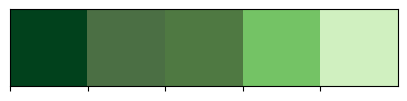

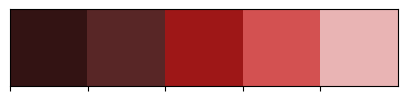

In [2]:
#Color definition for images
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [3]:
#Introducing labels in the dataset

dataset_path = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

Loading training dataset

In [18]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from collections import Counter

# Paths
train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
augmented_no_tumor_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training/no_tumor_augmented"

# Initialize lists
X_train = []
y_train = []

# Load original images
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]
for label in labels:
    folder_path = os.path.join(train_dir, label)
    for filename in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            X_train.append(img)
            y_train.append(label)

# Convert to NumPy arrays but keep lists to avoid dimension issues
X_train = np.array(X_train, dtype=object)
y_train = np.array(y_train)

print(f"Loaded {X_train.shape[0]} images from the Training dataset.")

# Load and merge No Tumor Augmented Images
if os.path.exists(augmented_no_tumor_dir):
    for filename in tqdm(os.listdir(augmented_no_tumor_dir), desc="Loading no_tumor_augmented"):
        img_path = os.path.join(augmented_no_tumor_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            X_train = list(X_train)  # Ensure X_train is a list
            X_train.append(img)
            y_train = np.append(y_train, "no_tumor")

# Convert X_train back to NumPy array
X_train = np.array(X_train, dtype=object)

# Count class distribution
class_counts = Counter(y_train)

print(f"Final dataset size after merging no_tumor: {X_train.shape[0]} images")
print("Class distribution before augmentation:")
for label, count in class_counts.items():
    print(f"{label}: {count} images")


Loading pituitary_tumor: 100%|██████████| 827/827 [00:00<00:00, 997.80it/s] 


Loaded 2870 images from the Training dataset.


Loading no_tumor_augmented: 100%|██████████| 425/425 [00:00<00:00, 3557.47it/s]

Final dataset size after merging no_tumor: 3295 images
Class distribution before augmentation:
glioma_tumor: 826 images
no_tumor: 820 images
meningioma_tumor: 822 images
pituitary_tumor: 827 images


In [20]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from collections import Counter

# Paths
train_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training"
augmented_dir = "/Users/glusker/Documents/courses/CAS_ADS/Module6/M6project/Training/no_tumor_augmented"

# Initialize lists
X_train = []
y_train = []

# Load original images
labels = ["glioma_tumor", "no_tumor", "meningioma_tumor", "pituitary_tumor"]
for label in labels:
    folder_path = os.path.join(train_dir, label)
    for filename in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            X_train.append(img)
            y_train.append(label)

# Convert to NumPy arrays but **keep lists to avoid dimension issues**
X_train = np.array(X_train, dtype=object)  
y_train = np.array(y_train)

print(f"Loaded {X_train.shape[0]} images from the Training dataset.")

# Load No Tumor Augmented Images and MERGE them with `no_tumor`
merged_no_tumor_images = []
merged_no_tumor_labels = []

if os.path.exists(augmented_dir):
    for filename in tqdm(os.listdir(augmented_dir), desc="Merging no_tumor_augmented"):
        img_path = os.path.join(augmented_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            merged_no_tumor_images.append(img)  
            merged_no_tumor_labels.append("no_tumor")

# Append merged no_tumor dataset
if len(merged_no_tumor_images) > 0:
    X_train = list(X_train)  
    X_train.extend(merged_no_tumor_images)  
    y_train = np.concatenate((y_train, np.array(merged_no_tumor_labels)), axis=0)

print(f"Final dataset size after merging no_tumor: {len(X_train)} images")


Loading pituitary_tumor: 100%|██████████| 827/827 [00:00<00:00, 1026.40it/s]


Loaded 2870 images from the Training dataset.


Merging no_tumor_augmented: 100%|██████████| 425/425 [00:00<00:00, 4436.17it/s]

Final dataset size after merging no_tumor: 3295 images


In [21]:
from collections import Counter

# Count current images before augmentation
class_counts = Counter(y_train)

print("Class distribution before augmentation:")
for label, count in class_counts.items():
    print(f"{label}: {count} images")


Class distribution before augmentation:
glioma_tumor: 826 images
no_tumor: 820 images
meningioma_tumor: 822 images
pituitary_tumor: 827 images


Yes, contrast-focused augmentation is the priority, especially for "no_tumor" vs "meningioma", since they are visually similar.

Plan for Augmentation:
For "no_tumor" (Heavy Augmentation)

Contrast adjustment (CLAHE)
Brightness shifts
Horizontal & vertical flips
Rotation (±15°)
Zoom (random crop)
Add Gaussian noise
For Other Classes (Light Augmentation)

Small rotations (±10°)
Horizontal flips
Slight brightness adjustments